In [3]:
using rhd2000evalboard, HDF5

In [2]:
#Opal Kelly XEM6010 board
x=open_board()

# Load Rhythm FPGA configuration bitfile (provided by Intan Technologies).
uploadFpgaBitfile();

#Initialize board
initialize_board()

#For 64 channel I think you do this twice (not positive but we can test)
enableDataStream(1, true)
setDataSource(0, 8)
setDataSource(1, 9)
println(rhd2000evalboard.dataStreamEnabled)
println(rhd2000evalboard.numDataStreams)

#Select per-channel amplifier sampling rate
setSampleRate(20000)

#Now that we have set our sampling rate, we can set the MISO sampling delay
#which is dependent on the sample rate. We assume a 3-foot cable.
setCableLengthFeet("PortA", 6.0)

Constructed
Scanning USB for Opal Kelly devices...
Found 1 Opal Kelly device(s)
Serial number of device 0 is 141100085D
FPGA configuration loaded.
Rhythm configuration file successfully loaded. Rhythm version number: 1
[1 1 0 0 0 0 0 0 0]
2


In [3]:
# Let's turn one LED on to indicate that the program is running.
ledArray=[1,1,0,0,0,0,0,0]
setLedDisplay(ledArray)

3


In [11]:
#short sequence
setMaxTimeStep(20000) #4140 causes error
setContinuousRunMode(false)
mytime=zeros(Int32,2)
electrode=[i => zeros(Int32,2) for i = 1:(2*32)]
saveOut="test.jld"
h5open(saveOut, "w") do myfile
    d=d_create(myfile, "time", Int32, ((1,),(-1,)), "chunk", (100,))
    d[1]=1
    for i=1:64
        e=d_create(myfile, string(i), Int32, ((1,),(-1,)),"chunk", (100,))
    end
end

usbDataRead=true

run()

while (usbDataRead || isRunning())
    #If Fifo contains words, they are read
    usbDataRead = readDataBlocks(1,mytime,electrode)
    if (length(mytime) >= 3000)
        (mytime, electrode) = queueToFile(mytime,electrode,saveOut)
        println(length(mytime))
    end
    
end

mytime = queueToFile(mytime,electrode,saveOut)

flush()

0, 28134
65536, 8438
65536, 31200
65536, 59466
131072, 13256
131072, 41390
196608, 9298
196608, 33928
196608, 58634
262144, 14148
262144, 37100
262144, 56470
327680, 22606
327680, 54282
393216, 15212
393216, 39790
458752, 12992
458752, 34060
458752, 55236
524288, 21380
524288, 44248
589824, 5178
589824, 31510
589824, 56244
655360, 13500
655360, 34574
655360, 61148
720896, 18404
720896, 39536
786432, 2064
786432, 23236
786432, 44354
851968, 1742
851968, 29854
851968, 52738
917504, 27662
917504, 54084
983040, 13228
983040, 43178
1048576, 2210
1048576, 28642
1048576, 55154
1114112, 19552
1114112, 42348
1179648, 1408
1179648, 26058
1179648, 48934
1245184, 11656
1245184, 36204
1245184, 57318
2
1310720, 56986
1376256, 23048
1376256, 44096
1441792, 8558
1441792, 31430
1441792, 27808
1441792, 22528
1441792, 17248
1441792, 11968
1441792, 6688
1441792, 1408
1376256, 61664
1376256, 56384
1376256, 51104
1376256, 45824
1376256, 40544
1376256, 35264
1376256, 29984
1376256, 24704
1376256, 19424
13762

In [1]:
using PyPlot

INFO: Loading help data...


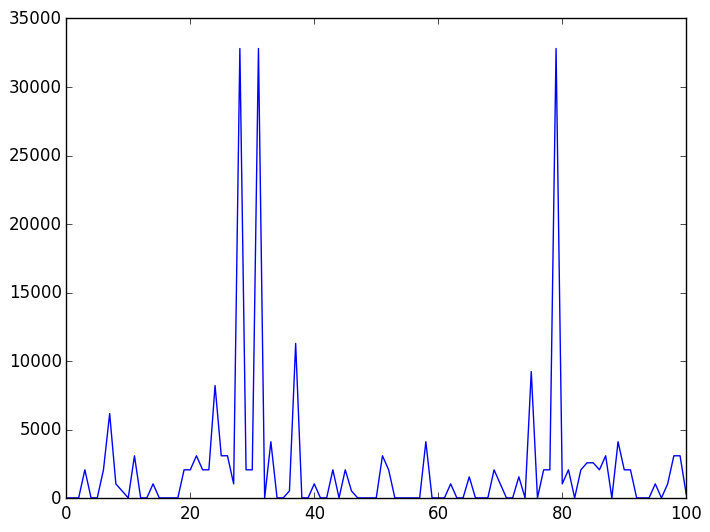

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1f53f59110>

In [21]:
h5open(saveOut) do hi
    e=d_open(hi, "20")
    PyPlot.plot(e[200:300])
end

(1,2)

2